# Amplitude embedding

In [38]:
import qiskit
from qiskit import *
from qiskit.visualization import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from math import ceil, log2
import numpy as np
import deprecation
from qiskit import QuantumCircuit, QuantumRegister
from qclib.state_preparation.mottonen import initialize as mottonen
from qclib.unitary import unitary as decompose_unitary #, cnot_count as cnots_unitary
from qclib.isometry import decompose as decompose_isometry #, cnot_count as cnots_isometry

# pylint: disable=maybe-no-member

def initialize(state_vector, low_rank=0, isometry_scheme='ccd', unitary_scheme='qsd',
                                                                        partition=None):
    """
    Low-rank state preparation using Schmidt decomposition.
    https://arxiv.org/abs/2111.03132
    For instance, to initialize the state a|00> + b|10> (|a|^2+|b|^2=1)
        $ state = [a, 0, b, 0]
        $ circuit = initialize(state)
    Parameters
    ----------
    state_vector: list of complex
        A unit vector representing a quantum state.
        Values are amplitudes.
    low_rank: int
        ``state`` low-rank approximation (1 <= ``low_rank`` < 2**(n_qubits//2)).
        If ``low_rank`` is not in the valid range, it will be ignored.
        This parameter limits the rank of the Schmidt decomposition. If the Schmidt rank
        of the state decomposition is greater than ``low_rank``, a low-rank approximation
        is applied.
    isometry_scheme: string
        Scheme used to decompose isometries.
        Possible values are ``'knill'`` and ``'ccd'`` (column-by-column decomposition).
        Default is ``isometry_scheme='ccd'``.
    unitary_scheme: string
        Scheme used to decompose unitaries.
        Possible values are ``'csd'`` (cosine-sine decomposition) and ``'qsd'`` (quantum
        Shannon decomposition).
        Default is ``unitary_scheme='qsd'``.
    partition: list of int
        Set of qubit indices that represent a part of the bipartition.
        The other partition will be the relative complement of the full set of qubits
        with respect to the set ``partition``.
        The valid range for indexes is ``0 <= index < n_qubits``. The number of indexes
        in the partition must be greater than or equal to ``1`` and less than or equal
        to ``n_qubits//2`` (``n_qubits//2+1`` if ``n_qubits`` is odd).
        Default is ``partition=list(range(n_qubits//2 + odd))``.
    Returns
    -------
    circuit: QuantumCircuit
        QuantumCircuit to initialize the state.
    """

    n_qubits = _to_qubits(len(state_vector))
    if n_qubits < 2:
        return mottonen(state_vector)

    circuit, reg_a, reg_b = _create_quantum_circuit(state_vector, partition)

    # Schmidt decomposition
    svd_u, singular_values, svd_v = schmidt_decomposition(state_vector, reg_a)

    rank, svd_u, svd_v, singular_values = \
        low_rank_approximation(low_rank, svd_u, svd_v, singular_values)

    # Schmidt measure of entanglement
    ebits = _to_qubits(rank)

    # Phase 1. Encodes the singular values.
    if ebits > 0:
        reg_sv = reg_b[:ebits]
        singular_values = singular_values / np.linalg.norm(singular_values)
        _encode(singular_values.reshape(rank, 1), circuit, reg_sv,
                                            isometry_scheme, unitary_scheme)

    # Phase 2. Entangles only the necessary qubits, according to rank.
    for j in range(ebits):
        circuit.cx(reg_b[j], reg_a[j])

    # Phase 3 and 4 encode gates U and V.T
    _encode(svd_u, circuit, reg_b, isometry_scheme, unitary_scheme)
    _encode(svd_v.T, circuit, reg_a, isometry_scheme, unitary_scheme)

    return circuit.reverse_bits()



# Schmidt routines



def schmidt_decomposition(state_vector, partition):
    """
    Execute the Schmidt decomposition of a state vector.
    Parameters
    ----------
    state_vector: list of complex
        A unit vector representing a quantum state.
        Values are amplitudes.
    partition: list of int
        Set of qubit indices that represent a part of the bipartition.
        The other partition will be the relative complement of the full set of qubits
        with respect to the set ``partition``.
        The valid range for indexes is ``0 <= index < n_qubits``. The number of indexes
        in the partition must be greater than or equal to ``1`` and less than or equal
        to ``n_qubits//2`` (``n_qubits//2+1`` if ``n_qubits`` is odd).
    """

    n_qubits = _to_qubits(len(state_vector))

    sep_matrix = _separation_matrix(n_qubits, state_vector, partition)

    return np.linalg.svd(sep_matrix)

def schmidt_composition(svd_u, svd_v, singular_values, partition):
    """
    Execute the Schmidt composition of a state vector.
    The inverse of the Schmidt decomposition.
    Returns
    -------
    state_vector: list of complex
        A unit vector representing a quantum state.
        Values are amplitudes.
    """

    n_qubits = _to_qubits(svd_u.shape[0]) + _to_qubits(svd_v.shape[1])

    #sep_matrix = svd_u @ np.diag(singular_values) @ svd_v
    sep_matrix = (svd_u * singular_values) @ svd_v

    state_vector = _undo_separation_matrix(n_qubits, sep_matrix, partition)

    return state_vector

def low_rank_approximation(low_rank, svd_u, svd_v, singular_values, rank_power_of_2=True):
    """
    Low-rank approximation from the SVD.
    """
    rank = singular_values.shape[0] # max rank

    effective_rank = _effective_rank(singular_values)

    if 0 < low_rank < rank or effective_rank < rank:
        if 0 < low_rank < effective_rank:
            effective_rank = low_rank

        if rank_power_of_2:
            # To use isometries, the rank needs to be a power of 2.
            rank = int(2**ceil(log2(effective_rank)))
        else:
            rank = effective_rank

        svd_u = svd_u[:,:rank]
        svd_v = svd_v[:rank,:]
        singular_values = singular_values[:rank]

    return rank, svd_u, svd_v, singular_values

def _separation_matrix(n_qubits, state_vector, partition):
    new_shape = (2 ** (n_qubits-len(partition)), 2 ** len(partition))

    qubit_shape = tuple([2] * n_qubits)
    # We need to swap qubits from their subsystem2 position to the end of the
    # mode as we expect that we do LSB to be on the left-most side.
    from_move = sorted(partition)
    to_move = (n_qubits - np.arange(1, len(partition) + 1))[::-1]

    sep_matrix = \
        np.moveaxis(np.array(state_vector).reshape(qubit_shape),
                                            from_move, to_move).reshape(new_shape)
    return sep_matrix

def _undo_separation_matrix(n_qubits, sep_matrix, partition):
    new_shape = (2 ** n_qubits, )

    qubit_shape = tuple([2] * n_qubits)

    to_move = sorted(partition)
    from_move = (n_qubits - np.arange(1, len(partition) + 1))[::-1]

    state_vector = \
        np.moveaxis(np.array(sep_matrix).reshape(qubit_shape),
                                            from_move, to_move).reshape(new_shape)
    return state_vector

def _effective_rank(singular_values):
    return sum(j > 10**-7 for j in singular_values)



# Auxiliary functions



def _to_qubits(n_state_vector):
    return int(log2(n_state_vector))

def _default_partition(n_qubits):
    odd = n_qubits % 2
    return list(range(n_qubits//2 + odd))

def _create_quantum_circuit(state_vector, partition):
    n_qubits = _to_qubits(len(state_vector))
    if partition is None:
        partition = _default_partition(n_qubits)

    complement = list(set(range(n_qubits)).difference(set(partition)))

    circuit = QuantumCircuit(n_qubits)

    return circuit, partition[::-1], complement[::-1]

def _encode(data, circuit, reg, iso_scheme='ccd', uni_scheme='qsd'):
    """
    Encodes data using the most appropriate method.
    """
    n_qubits = len(reg)
    rank = 0
    if data.shape[1] == 1:
        partition = _default_partition(n_qubits)
        _, svals, _ = schmidt_decomposition(data[:, 0], partition)
        rank = _effective_rank(svals)

    if data.shape[1] == 1 and (n_qubits % 2 == 0 or n_qubits < 4 or rank==1):
        # state preparation
        gate_u = initialize(data[:, 0], isometry_scheme=iso_scheme,
                                            unitary_scheme=uni_scheme)
    elif data.shape[0] > data.shape[1]:
        gate_u = decompose_isometry(data, scheme=iso_scheme)
    else:
        gate_u = decompose_unitary(data, decomposition=uni_scheme)

    # Apply gate U to the register reg
    circuit.compose(gate_u, reg, inplace=True)



# CNOT count



def cnot_count(state_vector, low_rank=0, isometry_scheme='ccd', unitary_scheme='qsd',
                                                        partition=None, method='estimate'):
    """
    Estimate the number of CNOTs to build the state preparation circuit.
    """

    n_qubits = _to_qubits(len(state_vector))
    if n_qubits < 2:
        return 0

    if partition is None:
        partition = _default_partition(n_qubits)

    cnots = 0

    # Schmidt decomposition
    svd_u, singular_values, svd_v = schmidt_decomposition(state_vector, partition)

    rank, svd_u, svd_v, singular_values = \
        low_rank_approximation(low_rank, svd_u, svd_v, singular_values)

    # Schmidt measure of entanglement
    ebits =  _to_qubits(rank)

    # Phase 1.
    if ebits > 0:
        singular_values = singular_values / np.linalg.norm(singular_values)
        cnots += _cnots(singular_values.reshape(rank, 1), isometry_scheme,
                                                          unitary_scheme, method)
    # Phase 2.
    cnots += ebits

    # Phases 3 and 4.
    cnots += _cnots(svd_u, isometry_scheme, unitary_scheme, method)
    cnots += _cnots(svd_v.T, isometry_scheme, unitary_scheme, method)

    return cnots

def _cnots(data, iso_scheme='ccd', uni_scheme='qsd', method='estimate'):
    n_qubits = _to_qubits(data.shape[0])

    rank = 0
    if data.shape[1] == 1:
        partition = _default_partition(n_qubits)
        _, svals, _ = schmidt_decomposition(data[:, 0], partition)
        rank = _effective_rank(svals)

    if data.shape[1] == 1 and (n_qubits % 2 == 0 or n_qubits < 4 or rank==1):
        return cnot_count(data[:, 0], isometry_scheme=iso_scheme,
                                       unitary_scheme=uni_scheme, method=method)
    if data.shape[0] > data.shape[1]:
        return cnots_isometry(data, scheme=iso_scheme, method=method)

    return cnots_unitary(data, decomposition=uni_scheme, method=method)



# Deprecated



@deprecation.deprecated(deprecated_in="0.0.7",
                        details="Use the initialize function instead")
def initialize_original(state_vector):
    """ State preparation using Schmidt decomposition arXiv:1003.5760.
        This function implements the original algorithm as defined in arXiv:1003.5760.
        It is kept here for didactic reasons.
        The ``initialize`` function should preferably be used.
    For instance, to initialize the state a|0> + b|1>
        $ state = [a, b]
        $ circuit = initialize_original(state)
    Parameters
    ----------
    state_vector: list of int
        A unit vector representing a quantum state.
        Values are amplitudes.
    Returns
    -------
    circuit: QuantumCircuit
        QuantumCircuit to initialize the state.
    """

    state = np.copy(state_vector)

    size = len(state)
    n_qubits = _to_qubits(size)

    odd = n_qubits % 2

    state.shape = (int(2**(n_qubits//2)), int(2**(n_qubits//2 + odd)))

    svd_u, singular_values, svd_v = np.linalg.svd(state)

    singular_values = singular_values / np.linalg.norm(singular_values)

    reg_a = QuantumRegister(n_qubits//2 + odd)
    reg_b = QuantumRegister(n_qubits//2)

    circuit = QuantumCircuit(reg_a, reg_b)

    if len(singular_values) > 2:
        circ = initialize_original(singular_values)
    else:
        circ = mottonen(singular_values)
    circuit.compose(circ, reg_b, inplace=True)

    for k in range(int(n_qubits//2)):
        circuit.cx(reg_b[k], reg_a[k])

    gate_u = decompose_unitary(svd_u, 'qsd')
    gate_v = decompose_unitary(svd_v.T, 'qsd')

    circuit.compose(gate_u, reg_b, inplace=True) # apply gate U to the first register
    circuit.compose(gate_v, reg_a, inplace=True) # apply gate V to the second register

    return circuit

## testing amplitude embedding

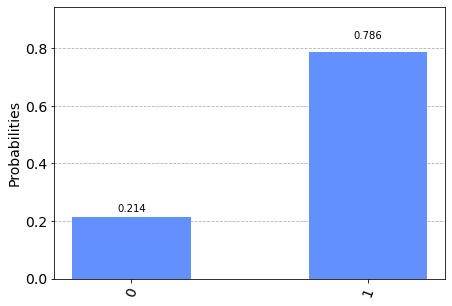

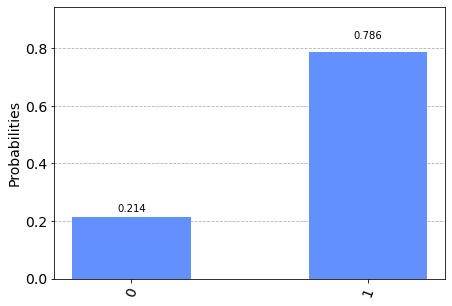

In [39]:
simulator = BasicAer.get_backend('qasm_simulator')
qc=QuantumCircuit(1,1)
state_prep = initialize(state_vector=[np.sqrt(0.2),np.sqrt(0.8)], low_rank=0, isometry_scheme='ccd', unitary_scheme='qsd',
                                                                        partition=None)
qc = qc.compose(state_prep)
qc.measure(0,0)
counts = execute(qc, backend=simulator, shots=1000).result().get_counts(qc)

plot_histogram(counts)

## ad-hoc data

In [40]:
from qiskit_machine_learning.datasets import ad_hoc_data

In [41]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False, one_hot=False, include_sample_total=True
)

In [42]:
train_features, test_features

(array([[0.87964594, 0.        ],
        [1.38230077, 4.33539786],
        [5.0893801 , 4.33539786],
        [4.58672527, 3.76991118],
        [4.46106157, 3.39292007],
        [0.81681409, 1.63362818],
        [4.58672527, 2.70176968],
        [4.08407045, 3.51858377],
        [3.76991118, 3.39292007],
        [4.27256601, 3.14159265],
        [2.95309709, 5.46637122],
        [4.77522083, 1.31946891],
        [4.20973416, 5.59203492],
        [6.22035345, 1.44513262],
        [0.06283185, 5.34070751],
        [2.63893783, 3.33008821],
        [4.90088454, 2.82743339],
        [2.32477856, 4.39822972],
        [5.15221195, 3.01592895],
        [4.27256601, 2.57610598],
        [4.83805269, 0.06283185],
        [0.18849556, 3.39292007],
        [0.87964594, 3.70707933],
        [5.15221195, 5.52920307],
        [3.20442451, 1.19380521],
        [0.37699112, 0.87964594],
        [6.03185789, 2.07345115],
        [5.0893801 , 0.62831853],
        [2.63893783, 1.63362818],
        [1.947

## Variational Circuit: Hardware-efficient ansatz

In [43]:
num_layers=3
def variational_circuit(x, param, num_layers):
    #qc=QuantumCircuit(len(x), 1)
    #num_qubits=len(x)
    
    qc=QuantumCircuit(1,1)
    #qc.h(0)
    #state_prep = initialize(state_vector=[complex(np.cos(x[0]/2)/np.sqrt(2), np.sin(x[0]/2)/np.sqrt(2)),
                                          #complex(np.cos(x[1]/2)/np.sqrt(2), np.sin(x[1]/2)/np.sqrt(2))],
    
    state_prep = initialize(state_vector=[np.sqrt(x[0]/(2*np.pi)),np.sqrt(x[1]/(2*np.pi))],
                            low_rank=0, 
                            isometry_scheme='ccd', 
                            unitary_scheme='qsd',
                            partition=None)
    qc = qc.compose(state_prep)
    
    """
    qc.h(range(len(x)))
    # ZZPauli Feature map    
    for k in range(len(x)):
        qc.rz(2*x[k],k)
    for i in range(len(x)-1):
        for j in range(len(x)):
            if(i<j):
                qc.cx(i,j)
                qc.rz(2*(np.pi - x[i])*(np.pi - x[j]), j)
                qc.cx(i, j)
                qc.barrier()
    """
    ###START LINEAR ENTANGLEMENT###
    """
    for k in range(num_layers):
        for j in range(len(x)):
            qc.ry(param[j + k*len(x)], j)
        for i in range(len(x)-1):
            qc.cx(i, i+1)
    """  
    for k in range(num_layers):        
        qc.ry(param[0 + k*2],0)
        qc.rx(param[1 + k*2],0)
        #qc.rz(param[2 + k*3],0)
    qc.barrier()
    
    
    ###END LINEAR ENTANGLEMENT###
    
    ###MEASUREMENT###
    qc.measure(0,0)
    return qc

In [44]:
num_params=2*num_layers
variational_circuit(train_features[6], np.zeros(num_params), num_layers).draw(fold=-1)

┌──────────────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐ ░ ┌─┐
q_0: ┤ UCRY(1.3092) ├┤ RY(0) ├┤ RX(0) ├┤ RY(0) ├┤ RX(0) ├┤ RY(0) ├┤ RX(0) ├─░─┤M├
     └──────────────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘ ░ └╥┘
c: 1/══════════════════════════════════════════════════════════════════════════╩═
                                                                               0

## Loss Function: Mean squared error (MSE)

$$L\left(x^*, l^*\right) = \frac{1}{n}\sum_{i}^{} \left(\langle p \rangle_{x_i} - l_i\right)^2$$

where $p$ is a parity function which was chose as $Z_0$.

In [45]:
backend = Aer.get_backend('statevector_simulator')
def loss_function(param):
    simulator = BasicAer.get_backend('qasm_simulator')
    #num_qubits=len(train_features[0])    
    zz_terms=[]
    for i in range(len(train_features)):
        circ=variational_circuit(train_features[i], param, num_layers=num_layers)
        
        counts=execute(circ, backend=simulator, shots=100).result().get_counts(circ)
        
        if '0' not in counts:
            counts['0']=0            
        if '1' not in counts:
            counts['1']=0            
        
        total_counts = counts['0'] + counts['1']
        
        #PARITY FUNCTION <Z>
        zz = (counts['0'] - counts['1'])/total_counts
        zz_terms.append(zz)
    loss=0
    #Mean squared error MSE
    for i in range(len(zz_terms)):
        if(train_labels[i]==1):
            loss = loss + (zz_terms[i] - 1)**2
        elif(train_labels[i]==0):
            loss = loss + (zz_terms[i] + 1)**2
    
    return loss/len(zz_terms)
        

In [46]:
test_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [47]:
np.random.seed(133)
guess = np.random.random(num_params)
loss_function(np.zeros(num_params))

1.4723099999999998

## Training circuit

In [48]:
from qiskit.aqua.components.optimizers import COBYLA,SLSQP,SPSA
from qiskit.algorithms.optimizers import COBYLA, ADAM

best_params = []
for i in range(5):
    np.random.seed(1345*i)
    guess = np.random.random(num_params)
    #optimizer = ADAM(maxiter=100, tol=1e-06, lr=0.05, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=False, snapshot_dir=None)
    optimizer = COBYLA(300, 0.01)
    ret = optimizer.optimize(num_vars=num_params, objective_function=loss_function, initial_point=guess)
    best_params.append(ret[0])
    print("iter: ", i, "energy: ", ret[1])


iter:  0 energy:  1.0316700000000003
iter:  1 energy:  0.9993899999999998
iter:  2 energy:  0.9708799999999996
iter:  3 energy:  1.02197
iter:  4 energy:  1.0173600000000003


In [49]:
#plt.plot(range(len(conv)),conv)

In [50]:
ret[1]

1.0173600000000003

In [51]:
ret[0]

array([ 0.95343837,  0.40929691,  0.93652946,  0.72029273, -0.1162697 ,
        0.47630736])

In [52]:
test_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

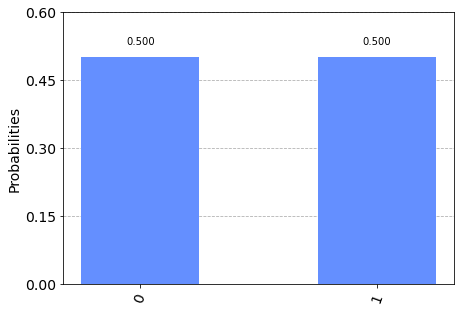

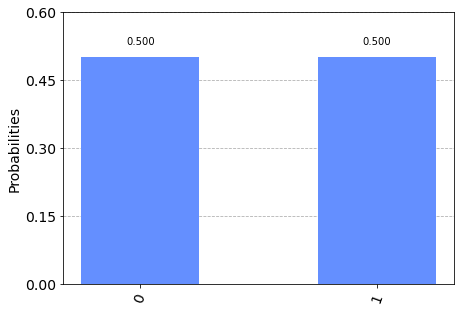

In [53]:
# testing a point
simulator = BasicAer.get_backend('qasm_simulator')
circ=variational_circuit(test_features[1], ret[0], num_layers=num_layers)
counts=execute(circ, backend=simulator, shots=100).result().get_counts(circ)
plot_histogram(counts)

## Testing

In [54]:
def test(test_data, opt_params):
    simulator = BasicAer.get_backend('qasm_simulator')
    circ=variational_circuit(test_data, opt_params, num_layers=num_layers)
    counts=execute(circ, backend=simulator, shots=100).result().get_counts(circ)

    if '0' not in counts:
        counts['0']=0            
    if '1' not in counts:
        counts['1']=0            

    total_counts = counts['0'] + counts['1']
    #PARITY FUNCTION Z1Z2
    zz = (counts['0'] - counts['1'])/total_counts        
    
    return zz
        

In [56]:

test_result=[]
label0=[]
label1=[]
for i in range(len(test_labels)):
    res=test(test_features[i], best_params[2])
    print('result: ', res, '   test class: ',test_labels[i])
    if(res>0):
        test_result.append(1)
        label1.append(res)
    elif(res<0):
        test_result.append(0)
        label0.append(res)

matching=0        
for k in range(len(test_labels)):
    print(test_labels[k],test_result[k])
    if(test_labels[k]==test_result[k]):
        matching += 1
print('SUCCESS RATE  : ', matching/len(test_result)*100,'%')
        

result:  0.02    test class:  0
result:  -0.02    test class:  0
result:  -0.2    test class:  0
result:  -0.08    test class:  0
result:  0.18    test class:  0
result:  -0.12    test class:  1
result:  0.06    test class:  1
result:  -0.16    test class:  1
result:  0.24    test class:  1
result:  0.04    test class:  1
0 1
0 0
0 0
0 0
0 1
1 0
1 1
1 0
1 1
1 1
SUCCESS RATE  :  60.0 %
